In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
from HGCal_ImageAlgo3D_kernel_cuda import *

demoevent = "id>=1 & id<=10 "
#demoevent = "id==1 "
DatasetDir  = '/home/zchen/Documents/ImageAlogrithm3D/data/'
#DatasetFile = 'CMSSW93X_pt35_pu200'
DatasetFile = 'CMSSW9304_partGun_PDGid22_x1000_E300.0To300.0_NTUP'


In [2]:
df = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_rechit.pkl")
dfgen = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_gen.pkl")

In [3]:
MAXDISTANCE        = np.float32(200)  #cm
LAYER_DISTANCE     = np.float32(0.5)  #cm
KERNAL_R           = np.float32(4.0)  #cm
KERNAL_R_NORM      = np.float32(2.0)  #cm
KERNAL_R_POWER     = np.float32(2.0)  #cm
KERNAL_LAYER       = np.float32(2.0)  #number of layer
DECISION_RHO_KAPPA = np.float32(10.0) #fractio of max rho
DECISION_NHD       = np.float32(4.0)  #cm
CONTINUITY_NHD     = np.float32(6.0)  #cm 

KERNAL_Z           = KERNAL_LAYER*LAYER_DISTANCE

# 0.Load Events

In [4]:
dfevt = df.query(demoevent)
dfevt = dfevt.reset_index(drop=True)

x = np.array(dfevt.x).astype(np.float32)
y = np.array(dfevt.y).astype(np.float32)
z = (np.array(dfevt.z) * LAYER_DISTANCE).astype(np.float32)
e = np.array(dfevt.energy).astype(np.float32)

N = np.int32(e.size)

# 1. Find rho and NearestHigher

In [45]:
rho     = np.zeros(N).astype(np.float32)
rhorank = np.zeros(N).astype(np.int32)
nh      = np.zeros(N).astype(np.int32)
nhd     = np.zeros(N).astype(np.float32)

d_x = cuda.mem_alloc(x.nbytes)
d_y = cuda.mem_alloc(y.nbytes)
d_z = cuda.mem_alloc(z.nbytes)
d_e = cuda.mem_alloc(e.nbytes)
d_rho     = cuda.mem_alloc(rho.nbytes)
d_rhorank = cuda.mem_alloc(rhorank.nbytes)
d_nh      = cuda.mem_alloc(nh.nbytes)
d_nhd     = cuda.mem_alloc(nhd.nbytes)

start = timer()
cuda.memcpy_htod(d_x,x)
cuda.memcpy_htod(d_y,y)
cuda.memcpy_htod(d_z,z)
cuda.memcpy_htod(d_e,e)

               
rho_cuda(d_rho,
         d_x, d_y, d_z, d_e,
         N, KERNAL_R, KERNAL_R_NORM, KERNAL_R_POWER, KERNAL_Z,
         grid=( int(N/1024)+1,1,1), block=(int(1024),1,1) )
         
rhoranknh_cuda(d_rhorank,d_nh,d_nhd,
               d_x,d_y,d_z,d_rho,
               N, MAXDISTANCE,
               grid=( int(N/1024)+1,1,1), block=(int(1024),1,1) )
         

cuda.memcpy_dtoh(rho,d_rho)
cuda.memcpy_dtoh(rhorank,d_rhorank)
cuda.memcpy_dtoh(nh,d_nh)
cuda.memcpy_dtoh(nhd,d_nhd)
end = timer()
print("number of rechits: {}".format(N))
print("time: {:3.6} ms".format(1000*(end - start)))

d_x.free()
d_y.free()
d_z.free()
d_e.free()
d_rho.free()
d_rhorank.free()
d_nh.free()
d_nhd.free()

number of rechits: 19905
time: 35.087 ms


# 2. Asign Clusters

In [46]:
cluster = -np.ones(N,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.1 convert rhorank to argsortrho 0(N)
argsortrho = np.zeros(N,int)
argsortrho[rhorank] = np.arange(N)

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid


# 2.3 asign clusters to seeds
for ith in range(N):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [47]:
dfevt['rho']     = pd.Series(rho,        index=dfevt.index)
dfevt['rhorank'] = pd.Series(rhorank,    index=dfevt.index)
dfevt['nh']      = pd.Series(nh,         index=dfevt.index)
dfevt['nhd']     = pd.Series(nhd,        index=dfevt.index)
dfevt['isseed']  = pd.Series(selectseed, index=dfevt.index)
dfevt['cluster'] = pd.Series(cluster,    index=dfevt.index)

# Make Plots

In [48]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

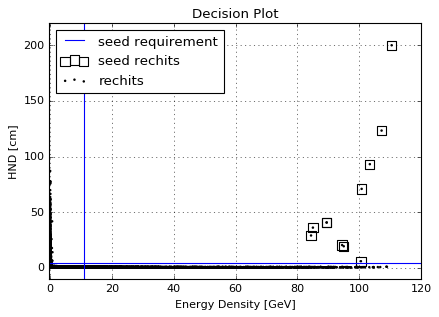

In [49]:
plt.scatter(rho[selectseed], nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(rho, nhd,marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("HND [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0.3)
plt.ylim(-10,220)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

plt.savefig("../../plot/decision_cuda00.png")

In [50]:
gen = dfgen.query(demoevent)

In [51]:
n = len(gen)
genx = np.zeros(n*2)
geny = np.zeros(n*2)
genz = np.zeros(n*2)
for i in range(n):
    genx[2*i]=np.array(gen.gx)[i]
    geny[2*i]=np.array(gen.gy)[i]
    genz[2*i]=np.array(gen.gz)[i]

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)

tempdf = dfevt.query('cluster>-1')
tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,tempdf.cluster.max()-tempdf.cluster
rechits = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=0.5*rho**0.5,color=tempclst,colorscale='Jet',cmax=tempclst.max(),cmin=0,opacity=0.5,
                                   line = dict(width = 0))) 
#tempdf = dfevt.query('(cluster==-1)')
tempdf = dfevt.query('(cluster==-1) & (energy>0.02)')

tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,-1
noise   = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=1,color="gray",opacity=0.5,
                                   line = dict(width = 0))) 

genpart = go.Scatter3d(x=genx,
                       y=genz,
                       z=geny,
                       mode='lines',marker=dict(size=0,color="red",opacity=1)) 

data = [rechits,noise,genpart]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='SinglePhoton300_PU000_cuda.html')

'file:///home/zchen/Documents/ImageAlogrithm3D/notebooks/demo/SinglePhoton300_PU000_cuda.html'